In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
pwd

'/home/thura/Desktop/smart-CCTV/notebook-files'

### Reading Sequence of frames and video-file

In [31]:
# writer4 = cv2.VideoWriter('/home/thura/Desktop/smart-CCTV/resultant-data/input-train-cross.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (600, 400))

In [32]:
# Reading Sequence of Frame
imgPath1 = '/home/thura/Desktop/smart-CCTV/video-data/GroundtruthSeq/RawImages'
imgPath2 = '/home/thura/Desktop/smart-CCTV/video-data/Campus'
imgPath3 = '/home/thura/Desktop/smart-CCTV/video-data/ShoppingMall_resized'
for imgName in sorted(os.listdir(imgPath1)):
    frame = cv2.imread(os.path.join(imgPath1, imgName))
    frame = cv2.resize(frame, dsize=(600, 400))
    # writer4.write(frame)
    cv2.imshow('Display', frame)
    if cv2.waitKey(30) & 0xff == 27:
        break

# writer4.release()
cv2.destroyAllWindows()

In [4]:
# Reading Video-file

videoPath = '/home/thura/Desktop/smart-CCTV/video-data/sroom4.avi'
video = cv2.VideoCapture(videoPath)

while(1):
    ret, frame = video.read()
    frame = cv2.resize(frame, dsize=(600, 400))
    cv2.imshow('Display', frame)
    if cv2.waitKey(30) & 0xff == 27:
        break
        
video.release()
cv2.destroyAllWindows()

### Change Detection Frame Differencing

* changes happening time by time I(t) -> I(t+1)
* changes = frame with changes - background frame

In [5]:
B = cv2.imread('/home/thura/Desktop/smart-CCTV/video-data/GroundtruthSeq/B.bmp')
I = cv2.imread('/home/thura/Desktop/smart-CCTV/video-data/GroundtruthSeq/I.bmp')

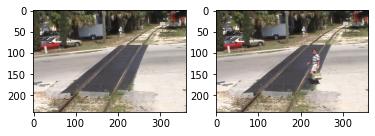

In [6]:
plt.subplot(121)
plt.imshow(B[:, :, ::-1])
plt.subplot(122)
plt.imshow(I[:, :, ::-1])

In [7]:
B.dtype

dtype('uint8')

In [8]:
# so that we can store float, convert int to float
B = np.float32(B)
I = np.float32(I)

In [9]:
C = (I - B)**2  # get changes object

In [10]:
C.shape

(240, 360, 3)

In [11]:
C_gray = np.sum(C, axis=2)  # sum the 3 channels of changes-object

In [12]:
C_gray.shape

(240, 360)

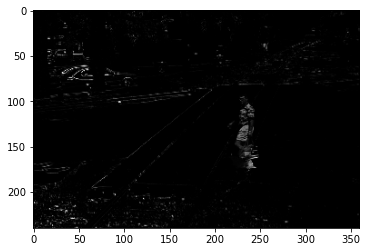

In [13]:
plt.imshow(C_gray, cmap='gray')

In [14]:
C_gray.max(), C_gray.mean()

(189017.0, 2068.9297)

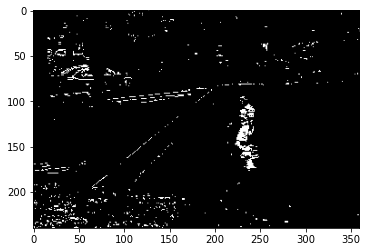

In [15]:
# thresholding with some statistical value for seeing significant changes

plt.imshow(C_gray > C_gray.mean() + 2*C_gray.std(), cmap='gray')

In [16]:
# Writing Resultant Video to desire directory
writer1 = cv2.VideoWriter('/home/thura/Desktop/smart-CCTV/resultant-data/component-shmall.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (2*600, 400))

# Writing frame-changes Video to desire directory
# writer2 = cv2.VideoWriter('/home/thura/Desktop/smart-CCTV/resultant-frame-changes-videos/train-cross.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (2*600, 400))

## Below Code

#### 1- Background Subtraction for foreground image by using Gaussian method
Background-subtraction is better than frame-diferencing for better estimation of changes.

#### 2- Denoising using Morphology with OpenCV

#### 3- Connected Components
Remove small components under threshold and just leave components greater than threshold.

#### 4- Take object detection on frame-with-changes

#### 5- Save these changes frame and object detected frames

#### 6- Display and view these saved frames

In [17]:
def keepLargeComponents(labelImg, th):
    """
    Keep unique and large labels than threshold, then return the sum value between 0-255 gray img
    """
    binaryImg = np.zeros(labelImg.shape) < 0 # for assuming label are greater than zero
    unique_labels = np.unique(labelImg.flatten())  # make labelImg to flatten vector and take unique
    for label in unique_labels:
        if label == 0:
            pass
        else:
            labelImg2 = labelImg==label  # just take unique label of labelImg
            if np.sum(labelImg2) > th:
                binaryImg = binaryImg | labelImg2
                
    return np.float32(255*binaryImg)

In [23]:
import cvlib as cv
from cvlib.object_detection import draw_bbox

writer3 = cv2.VideoWriter('/home/thura/Desktop/smart-CCTV/resultant-frame-changes-videos/campus.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (600, 400))

def saveSeq(F, counter, th, outPath):
    if len(F) < th:
        pass
    else:
        c = 1
        for frame in F:
            imgName = str(counter)+'_'+str(c)+'.jpg'
            finalPath = os.path.join(outPath, imgName)
            
            # For object detection
            bbox, labels, conf = cv.detect_common_objects(frame)
            frame = draw_bbox(frame, bbox, labels, conf)
            
            cv2.imwrite(finalPath, frame)
            writer3.write(frame)
            c += 1
        writer3.release()

In [24]:
def displaySeq(outPath):
        
    for imgName in os.listdir(outPath):
        
        try:
            frame = cv2.imread(os.path.join(outPath, imgName))
            frame = cv2.resize(frame, dsize=(600, 400))
            
            cv2.imshow('Display', frame)
            
            if cv2.waitKey(30) & 0xff == 27:
                break
            
        except:
            break
    
    cv2.destroyAllWindows()

In [25]:
# Reading Sequence of Frame
imgPath1 = '/home/thura/Desktop/smart-CCTV/video-data/GroundtruthSeq/RawImages'
imgPath2 = '/home/thura/Desktop/smart-CCTV/video-data/Campus'
imgPath3 = '/home/thura/Desktop/smart-CCTV/video-data/ShoppingMall_resized'

# Subtract background and show foreground with Gaussian method
fgModel = cv2.createBackgroundSubtractorMOG2()

# when the changes start 
leastNumberOfFrames = 5  # minimun threshold for frame duration
idx = []
F = []
counter = 0

# saving-paths of frame with changes
outPath1 = '/home/thura/Desktop/smart-CCTV/save-frame-with-changes-1'  # rail-road images
outPath2 = '/home/thura/Desktop/smart-CCTV/save-frame-with-changes-2'  # campus images

### Don't forget to change yr desire 2*imgPath and 2*OutPath ###

for imgName in sorted(os.listdir(imgPath2)):  # change path
    
    counter += 1 # to know at which frame at the present
    
    frame = cv2.imread(os.path.join(imgPath2, imgName))  # change path
    frame = cv2.resize(frame, dsize=(600, 400))
    
    fgMask = fgModel.apply(frame)
    
    # Denoising using Morphology
    kernelStruct = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    fgMask = cv2.morphologyEx(np.float32(fgMask), cv2.MORPH_OPEN, kernelStruct)
    
    
    # Connected component, convert binary array
    num_labels, labels_img = cv2.connectedComponents(np.array(fgMask>0, np.uint8))  # uint8 require for connectedComponent function
    fgMask = keepLargeComponents(labels_img, 1000) 
    
    # Check significant chages
    if np.sum(fgMask) > 0:
        idx.append(counter)
        F.append(frame)
    
    # Save sequence if idex start with 2 and time is consecutiv
    if len(idx) >= 2 and idx[-1] > idx[-2]+1:
        saveSeq(F, counter, leastNumberOfFrames, outPath2)  # Change tho outPath according to sequence-type
        # For another changes of sequences
        idx = []
        F = []
    
    showMask = np.zeros(frame.shape, np.uint8)
    showMask[:, :, 0], showMask[:, :, 1], showMask[:, :, 2] = fgMask, fgMask, fgMask
    frame2 = np.hstack((frame, showMask))
    
    # write/save video
    # writer.write(frame2)
    
    cv2.imshow('Display', frame2)
    if cv2.waitKey(30) & 0xff == 27:
        break

# writer.release()
saveSeq(F, counter, leastNumberOfFrames, outPath2)   # Change path same with above
cv2.destroyAllWindows()

In [28]:
# Writing frame-changes Video to desire directory
outPath1 = '/home/thura/Desktop/smart-CCTV/save-frame-with-changes-1/'
outPath2 = '/home/thura/Desktop/smart-CCTV/save-frame-with-changes-2'

displaySeq(outPath2)